In [12]:
from datetime import datetime
from matplotlib import pyplot as plt 
import numpy as np
from tqdm import tqdm,trange

import dreamcoder as dc
from dreamcoder.frontier import Frontier, FrontierEntry
from dreamcoder.fragmentGrammar import FragmentGrammar
from dreamcoder.grammar import Grammar
from dreamcoder.program import Program
from dreamcoder.program import Abstraction
from dreamcoder.utilities import numberOfCPUs

import dreamcoder.domains.quantum_circuits.primitives as pr
from dreamcoder.domains.quantum_circuits.primitives import execute_program, get_qiskit_circuit, tcircuit, no_op, QiskitTester
from dreamcoder.domains.quantum_circuits.tasks import QuantumTask


%load_ext line_profiler
%load_ext autoreload
%autoreload 2


The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
n_qubit_tasks = 3
evaluationTimeout = 0.01

enum_settings = {
    "maximumFrontier": 1,
    
}
library_settings = {
    "structurePenalty": 6,  # increase regularization 3 4 (it was 1), look at a few in [1,15]
    "pseudoCounts": 10,  # increase to 100, test a few values
    "topK": 2,
    "arity": 3,
}

# Unfortunately these flags are set globally
dc.domains.quantum_circuits.primitives.GLOBAL_LIMITED_CONNECTIVITY = False
dc.domains.quantum_circuits.primitives.GLOBAL_NQUBIT_TASK = n_qubit_tasks 

In [14]:
def visualize_program(code: str):
    "Helper function to plot a circuit program"
    arguments = (*range(n_qubit_tasks), (n_qubit_tasks, ()))
    program = Program.parse(code)
    circuit = execute_program(program, arguments)
    reconstructed_circuit = get_qiskit_circuit(circuit)
    print(code)
    print(reconstructed_circuit.circuit)

In [15]:
primitives = [
    pr.p_hadamard,
    pr.p_t,
    pr.p_tdg,
    pr.p_cnot,
    pr.p_x,
]
grammar = Grammar.uniform(primitives) # continuationType=tcircuit not supported (non-unary argument)

In [27]:
programs = [
    "(lambda (lambda (lambda (lambda (cnot (x $0 $1) $1 $2)))))",
    "(lambda (lambda (lambda (lambda (cnot (x (x (x $0 $1) $1) $1) $1 $2)))))",
    # "(lambda (lambda (lambda (lambda (x (x (x $0 $1) $1) $1) ))))",
    "(lambda (lambda (lambda (lambda (cnot (x (h (x $0 $2) $2) $2) $2 $1)))))",
    "(lambda (lambda (lambda (lambda (cnot (x (h (x (h $0 $2) $2) $2) $2) $2 $1)))))",
    "(lambda (lambda (lambda (lambda (cnot (x (h (x (h (x (h (x $0 $2) $2) $2) $2) $2) $2) $2) $2 $1)))))",
]
visualize_program(programs[0])

(lambda (lambda (lambda (lambda (cnot (x $0 $1) $1 $2)))))
     ┌───┐     
q_0: ┤ X ├──■──
     └───┘┌─┴─┐
q_1: ─────┤ X ├
          └───┘
q_2: ──────────
               


In [28]:
code = "(lambda (lambda (lambda (lambda (cnot (x (x $0 $1) $1) $1 $2)))))"
arguments = (*range(n_qubit_tasks), (n_qubit_tasks, ()))
program = Program.parse(code)
circuit = execute_program(program, arguments)
reconstructed_circuit = get_qiskit_circuit(circuit)

In [29]:
code = "(lambda (lambda (lambda (rz $0 $2 $1))))"
arguments = (1.3,*range(1), (1, ()))
program = Program.parse(code)
circuit = execute_program(program, arguments)
reconstructed_circuit = get_qiskit_circuit(circuit)

In [30]:
print(circuit)
reconstructed_circuit.circuit.draw()

(1, (('rz', 1.3, 0),))


┌─────────┐
q: ┤ Rz(1.3) ├
   └─────────┘

In [31]:
reconstructed_circuit.circuit.draw()

┌─────────┐
q: ┤ Rz(1.3) ├
   └─────────┘

In [32]:
circuit

(1, (('rz', 1.3, 0),))

In [33]:
# Generate a few example tasks
solutions = {}  # dict of task:solution

for code in programs:
    arguments = (*range(n_qubit_tasks), (n_qubit_tasks, ()))
    program = Program.parse(code)
    circuit = execute_program(program, arguments)
    task = QuantumTask(f"t_{len(solutions):03d}_{code}", circuit)

    # 0 = solved, -inf = not solved
    likelihood = task.logLikelihood(program, evaluationTimeout)
    prior = grammar.logLikelihood(task.request, program)

    frontier_entry = FrontierEntry(
        program=program, logLikelihood=likelihood, logPrior=prior
    )

    solutions[task] = Frontier(
        frontier=[frontier_entry],  # multiple solutions are allowed
        task=task,
    )
tasks = list(solutions.keys())

In [9]:
generator = dc.dreamcoder.ecIterator(
    grammar=grammar,
    tasks=tasks,
    testingTasks=[],
    outputPrefix=f"experimentOutputs/quantum/{datetime.now().isoformat()}",
    enumerationTimeout=10,
    iterations=3,
    taskBatchSize=len(tasks),  # smaller should be faster
    taskReranker="randomShuffle",  # default
    CPUs=1,#numberOfCPUs(),
    solver="bottom",
    compressor="pypy",
    **enum_settings,
    **library_settings,
)

NameError: name 'tasks' is not defined

In [21]:
for result in generator:
    ...

dreamcoder.py:191 > Warning: Recognition model needs feature extractor. Ignoring recognition model.
dreamcoder.py:270 > Running EC on polymathiclin033.flatironinstitute.org @ 2024-08-20 08:35:48.819377 with 1 CPUs and parameters:
dreamcoder.py:273 > 	 noConsolidation  =  False
dreamcoder.py:273 > 	 iterations  =  3
dreamcoder.py:273 > 	 enumerationTimeout  =  10
dreamcoder.py:273 > 	 useRecognitionModel  =  False
dreamcoder.py:273 > 	 topk_use_only_likelihood  =  False
dreamcoder.py:273 > 	 pseudoCounts  =  10
dreamcoder.py:273 > 	 aic  =  1.0
dreamcoder.py:273 > 	 structurePenalty  =  6
dreamcoder.py:273 > 	 arity  =  3
dreamcoder.py:273 > 	 taskBatchSize  =  6
dreamcoder.py:273 > 	 taskReranker  =  randomShuffle
dreamcoder.py:273 > 	 storeTaskMetrics  =  False
dreamcoder.py:273 > 	 rewriteTaskMetrics  =  True
dreamcoder.py:273 > 	 maximumFrontier  =  1
dreamcoder.py:273 > 	 solver  =  bottom
dreamcoder.py:273 > 	 topK  =  2
dreamcoder.py:274 > 	 evaluationTimeout  =  1.0
dreamcoder.p

grammar.py:2048 >  -- Bottom up enumeration, cost 25
grammar.py:2048 >  -- Bottom up enumeration, cost 26
grammar.py:2048 >  -- Bottom up enumeration, cost 27
grammar.py:2048 >  -- Bottom up enumeration, cost 28
grammar.py:2048 >  -- Bottom up enumeration, cost 29
grammar.py:2048 >  -- Bottom up enumeration, cost 30
grammar.py:2048 >  -- Bottom up enumeration, cost 31
grammar.py:2048 >  -- Bottom up enumeration, cost 32
grammar.py:2048 >  -- Bottom up enumeration, cost 33
grammar.py:2048 >  -- Bottom up enumeration, cost 34
grammar.py:2048 >  -- Bottom up enumeration, cost 35
grammar.py:2048 >  -- Bottom up enumeration, cost 36
enumeration.py:446 > Enumerated 33140 programs
dreamcoder.py:565 > Generative model enumeration results:
dreamcoder.py:566 > HIT t_003_(lambda (lambda (lambda (lambda (cnot (x (h (x $0 $2) $2) $2) $2 $1))))) w/ (lambda (lambda (lambda (lambda (cnot (x (h (x $0 $2) $2) $2) $2 $1))))) ; log prior = -14.451859 ; log likelihood = 0.000000
HIT t_002_(lambda (lambda (

In [25]:
result.grammars[2].logLikelihood(tasks[1].request, Program.parse(programs[1]))

NameError: name 'result' is not defined

In [48]:
tasks[0].logLikelihood(programs[0])

0.0

In [25]:
print(grammar)

print(result.grammars[-1])

0.000000	t0	$_
0.000000	tcircuit -> int -> tcircuit	h
0.000000	tcircuit -> int -> tcircuit	t
0.000000	tcircuit -> int -> tcircuit	tdg
0.000000	tcircuit -> int -> int -> tcircuit	cnot
0.000000	tcircuit -> int -> tcircuit	x
-0.092373	t0	$_
-0.587787	tcircuit -> int -> tcircuit	x
-0.656780	tcircuit -> int -> tcircuit	h
-0.656780	tcircuit -> int -> int -> tcircuit	cnot
-0.993252	tcircuit -> int -> tcircuit	t
-0.993252	tcircuit -> int -> tcircuit	tdg


In [34]:
frontiers = [f for f in solutions.values()]

new_grammar, new_frontiers = FragmentGrammar.induceFromFrontiers(
    g0=grammar, frontiers=frontiers, **library_settings
)

new_grammar, new_frontiers

fragmentGrammar.py:298 > Inducing a grammar from 5 frontiers
fragmentGrammar.py:327 > Starting score -111.17389390053093


fragmentGrammar.py:334 > Proposed 825 fragments.
fragmentGrammar.py:365 > New primitive of type tcircuit	(x (h $0 $1) $1)	
(score = -111.094551; dScore = 0.079343; <uses> = 5.802837)
fragmentGrammar.py:378 > 	(<uses> in rewritten frontiers: 6.000000)
fragmentGrammar.py:334 > Proposed 81 fragments.
fragmentGrammar.py:397 > Old joint = -80.930409	New joint = -63.053194

fragmentGrammar.py:417 > 0.000000 / 22.000000	h
fragmentGrammar.py:417 > 0.000000 / 22.000000	t
fragmentGrammar.py:417 > 0.000000 / 22.000000	tdg
fragmentGrammar.py:417 > 5.000000 / 22.000000	cnot
fragmentGrammar.py:417 > 6.000000 / 22.000000	x
fragmentGrammar.py:417 > 6.000000 / 22.000000	#(lambda (lambda (x (h $0 $1) $1)))


(<dreamcoder.grammar.Grammar at 0x7fa6ba3aeac0>,
 [Frontier(entries=[FrontierEntry(program=(lambda (lambda (lambda (lambda (cnot (x $0 $1) $1 $2))))), logPrior=-8.443458133549708, logLikelihood=0.0], task=t_000_(lambda (lambda (lambda (lambda (cnot (x $0 $1) $1 $2)))))),
  Frontier(entries=[FrontierEntry(program=(lambda (lambda (lambda (lambda (cnot (x (x (x $0 $1) $1) $1) $1 $2))))), logPrior=-14.355792502774959, logLikelihood=0.0], task=t_001_(lambda (lambda (lambda (lambda (cnot (x (x (x $0 $1) $1) $1) $1 $2)))))),
  Frontier(entries=[FrontierEntry(program=(lambda (lambda (lambda (lambda (cnot (#(lambda (lambda (x (h $0 $1) $1))) $2 (x $0 $2)) $2 $1))))), logPrior=-11.433719529505309, logLikelihood=0.0], task=t_002_(lambda (lambda (lambda (lambda (cnot (x (h (x $0 $2) $2) $2) $2 $1)))))),
  Frontier(entries=[FrontierEntry(program=(lambda (lambda (lambda (lambda (cnot (#(lambda (lambda (x (h $0 $1) $1))) $2 (#(lambda (lambda (x (h $0 $1) $1))) $2 $0)) $2 $1))))), logPrior=-11.4678137

In [16]:
type(new_grammar.primitives[-1])

dreamcoder.program.Invented

In [17]:
new_grammar.primitives[-1]

#(lambda (lambda (x (h $0 $1) $1)))

In [18]:
print(new_grammar)

-0.173272	t0	$_
-0.693147	tcircuit -> int -> tcircuit	x
-0.757686	tcircuit -> int -> int -> tcircuit	cnot
-1.163151	tcircuit -> int -> tcircuit	h
-1.163151	tcircuit -> int -> tcircuit	t
-1.163151	tcircuit -> int -> tcircuit	tdg
-0.693147	int -> tcircuit -> tcircuit	#(lambda (lambda (x (h $0 $1) $1)))


In [19]:
p = new_frontiers[0].entries[0].program

In [20]:
p.body.body.body.body

(cnot (x $0 $1) $1 $2)

### Defining a program

In [15]:
arguments = (*range(n_qubit_tasks), (n_qubit_tasks, ()))
program = Program.parse(code)
circuit = execute_program(program, arguments)
reconstructed_circuit = get_qiskit_circuit(circuit)

In [16]:
# p =Program.parse("(lambda (lambda (lambda (lambda (cnot (#(lambda (lambda (x (h $0 $1) $1))) $2 (x $0 $2)) $2 $1)))))")
# p =Program.parse("cnot")
p = Program.parse("(lambda $1)")
p

(lambda $1)

In [17]:
p.evaluate([3])([])

3

In [18]:
p.body.body.body.body.f.f.x.f.f.body.body.body.f.x.x

AttributeError: 'Index' object has no attribute 'body'

In [21]:
ee = p.evaluate([1])
ee(no_op(2))(1)(0)

import inspect
inspect.getsource(ee)

NameError: name 'ee' is not defined

---

### Rotations

In [6]:
pr.skd =  pr.solovay_kitaev_synthesis.SolovayKitaev(2)

In [7]:
x,y,z = np.random.uniform(0,2*np.pi,3)
with QiskitTester(1) as QT:
    # QT.circuit.append(qk.circuit.library.CPhaseGate(np.pi/4), (0, 1))
    QT.circuit.u(x,y,z,0)

In [8]:
QT.get_result(QT.circuit)

array([[ 0.91187443+0.j        , -0.3827602 +0.14825536j],
       [-0.36792091+0.18198689j, -0.61615149+0.67221449j]])

In [60]:
with QiskitTester(1) as QT:
    QT.circuit.append(qk.circuit.library.PhaseGate(np.pi*3/5), (0,))
    # QT.circuit.u(x,y,z,0)
transpiled = qk.transpile(QT.circuit)
circuit2 = pr.pm.run(transpiled)
discretized = pr.skd(circuit2)
discretized = qk.transpile(discretized, basis_gates=pr.basis_gates + [ "ry", "rx"])
print(discretized.depth())
transpiled.draw(), circuit2.draw(),discretized.draw()

p [1.8849555921538759]
3


(   ┌─────────┐
 q: ┤ P(3π/5) ├
    └─────────┘,
    ┌─────────┐
 q: ┤ P(3π/5) ├
    └─────────┘,
 global phase: 3π/10
    ┌─────────────┐┌────────────┐┌────────────┐
 q: ┤ Rx(-1.5624) ├┤ Ry(1.8993) ├┤ Rx(1.5909) ├
    └─────────────┘└────────────┘└────────────┘)

In [9]:
import qiskit as qk
decompositions = []
# for th in tqdm(np.linspace(0,np.pi/2,50)):
for _ in trange(5000):
    x,y,z = np.random.uniform(0,2*np.pi,3)
    with QiskitTester(1) as QT:
        # QT.circuit.append(qk.circuit.library.CPhaseGate(np.pi/4), (0, 1))
        QT.circuit.u(x,y,z,0)
    transpiled = qk.transpile(QT.circuit)
    circuit2 = pr.pm.run(transpiled)
    discretized = pr.skd(circuit2)
    decompositions.append(discretized.depth())
decompositions = np.array(decompositions)

  0%|          | 4/5000 [00:00<02:07, 39.09it/s]

  0%|          | 9/5000 [00:00<01:58, 42.01it/s]

u [2.6930410745410804, 2.510893698639475, 0.980368598857567]
u [4.15668551619779, 1.4058463963817456, 5.98640168950628]
u [1.5784567667060496, 1.155717884707915, 2.0259786330715337]
u [5.717083927702921, 5.619137517236983, 1.9605622776865859]
u [5.329669638659814, 5.333099046777051, 1.548123038166898]
u [5.422752485558432, 2.365755733517085, 0.3259703233514861]
u [2.8336756775710263, 5.343417369496987, 5.069177613277613]
u [5.679203397674595, 1.6981753889191007, 2.549874039537377]
u [6.166470093915839, 6.08271626090361, 1.2212854340318207]


  0%|          | 14/5000 [00:00<01:59, 41.61it/s]

u [1.4247450522248828, 5.082675542472501, 0.4712755448666198]
u [3.6343102386617963, 4.064777740950057, 2.2433857751241812]
u [3.176950631232649, 4.753294295170859, 3.3085959443169153]
u [4.086375242216997, 6.047194182383003, 2.0274764615398446]
u [3.9006604545956236, 1.030365229064036, 5.38246073341703]
u [5.436625628154465, 4.831398705609296, 1.436461632152117]
u [1.5210506887576374, 2.779893778149196, 1.121356336015923]
u [4.146283173039051, 1.831982815278135, 2.4236564130083433]
u [4.528724286959191, 3.4469544156399965, 3.6368905327004515]


  0%|          | 24/5000 [00:00<01:56, 42.83it/s]

u [2.2284687598679547, 0.11504159614458247, 5.297936159177894]
u [5.612884844548225, 5.889691524736234, 5.132862500123487]
u [0.3925840971891634, 0.26755853586416445, 6.236192294978375]
u [5.155956960641303, 3.5386175251661016, 0.8475759270539697]
u [3.9295109867517963, 1.321538752725174, 1.5747006539465174]
u [0.012913862403528212, 0.8116420360081423, 0.715534023956054]
u [0.8553587162746099, 4.087654162629081, 5.948526716769615]
u [4.795294034290307, 4.849293722478426, 4.036221234581157]
u [1.0526873873725602, 5.889403395564173, 0.6315771350548015]


  1%|          | 34/5000 [00:00<01:55, 43.07it/s]

u [4.939944844451128, 4.773397994222029, 0.15912966315549304]
u [0.3740808519584632, 6.213447049566862, 4.056073652424316]
u [4.543316262320842, 5.773038457993008, 3.868090353096242]
u [3.569700543402302, 5.040165859136302, 4.354959571504322]
u [4.862009869739878, 0.95167259497952, 2.4974579185638595]
u [5.584013069973051, 5.371951431075189, 2.12949461664124]
u [4.451889008989157, 5.579514040774899, 2.2965756433420577]
u [0.6897223793662565, 2.409353863250471, 4.119461489563427]
u [3.2897951680759348, 5.613982499083974, 6.226845021816588]


  1%|          | 44/5000 [00:01<01:54, 43.47it/s]

u [1.2160255593372982, 3.0590709353749928, 2.7596739299115844]
u [0.09557632631414181, 4.265544118045305, 3.485075763466581]
u [5.947273526595957, 5.301708427765491, 3.8124172053048975]
u [3.803677800254588, 2.5352792343181427, 4.700327130293002]
u [1.6488220824127144, 5.042812298189561, 5.440966003550268]
u [5.514307578255496, 3.2085725399628338, 5.6696990091531]
u [1.1773293647063665, 0.5951063840845388, 0.7985709509865448]
u [0.8360708084234117, 1.0113972268540352, 2.0683792709555595]
u [0.5088145560501013, 4.519949800212667, 1.855645595431053]


  1%|          | 49/5000 [00:01<01:53, 43.48it/s]

u [5.199253241552158, 4.601359622895195, 4.842823701589006]
u [0.9507592043481953, 4.846544035385605, 5.899760699343172]
u [6.277233894006546, 1.7723257052621122, 1.5793121191454909]
u [0.07827273410230823, 6.1707742734921815, 2.302737986132741]
u [5.331348736656137, 5.388652166270237, 1.744014819698715]
u [4.93026851090958, 5.4402752363393505, 3.295593245422245]
u [4.079933698933083, 2.5509565825837233, 5.783943486557872]
u [1.2711775023377392, 2.3892146207399794, 5.673326623351467]
u [1.4779820471587795, 1.4120878510204333, 1.8529019323960605]


  1%|          | 59/5000 [00:01<01:54, 43.01it/s]

u [6.234842561117666, 1.4478872876261601, 2.987829438680679]
u [5.9044187056995225, 3.326733946214709, 0.4602500065486355]
u [5.84491113702602, 6.13153110371265, 5.978640930291222]
u [2.234741625545251, 0.894497094472082, 0.25997505134657956]
u [2.1338405034208443, 1.0898050593492938, 4.355738918451888]
u [0.7669008490027226, 0.2846009367057913, 1.784150267848969]
u [2.1387925083248693, 0.11836610645557737, 3.377771625665568]
u [3.83610780724094, 2.5305629951295048, 6.195351140349596]
u [1.309432124500464, 0.6764839616884549, 1.5400632311460754]
u [4.7001834016686646, 1.5416902844076432, 1.5893727166447695]


  1%|▏         | 69/5000 [00:01<01:53, 43.46it/s]

u [5.665317516365006, 5.323055788455398, 5.659784217377947]
u [2.5607701654780235, 6.010963344245939, 4.160088763812132]
u [4.547390189198568, 3.3884805804218394, 5.954195851126672]
u [1.456161256452755, 6.0945107206580715, 4.945257382172235]
u [0.7814131373798227, 4.079011514770232, 4.4717174226990135]
u [3.6888538373586064, 3.2606208800768215, 3.305595524205777]
u [0.3525804910494042, 1.7971375107777081, 1.500431706424167]
u [1.695662636790244, 6.03697662617786, 0.16653733507888832]
u [4.2166624923679965, 5.214934940470365, 0.11088502337909316]
u [4.088128206018601, 3.0721828158585587, 6.190980850552536]


  2%|▏         | 79/5000 [00:01<01:52, 43.77it/s]

u [0.47823107073971705, 1.19248157488803, 3.3786776345063183]
u [2.9507551321941525, 0.7614996556203227, 0.7201000969049348]
u [1.3668224697486264, 4.242433831596052, 0.3057722041615959]
u [5.77275592783608, 1.014382394925965, 1.238588993013827]
u [0.4615157156217314, 4.288902503720053, 5.566869420172569]
u [1.5755823012266728, 5.262674011096735, 2.044526658493583]
u [2.464503619046677, 2.5934627457554353, 1.2930191199738104]
u [1.320356464883873, 1.5839346325166204, 2.966991607554276]
u [0.31476895599650323, 2.157711801736265, 0.4664799180572414]
u [4.526585508166471, 5.257966292887755, 0.7839018171982525]


  2%|▏         | 92/5000 [00:02<01:34, 51.76it/s]

u [2.9302847161202266, 2.9211594764028757, 4.196041680169302]
u [5.912786239004172, 4.389043730642667, 3.8838913431595423]
u [2.239294265566681, 2.6582602433693965, 3.9937610186722297]
u [4.99863286709583, 0.19241626708967532, 4.0129595628197015]
u [1.0532407961360966, 0.07197930687447135, 3.3191990144268493]
u [2.4044869817557437, 0.5047743739317319, 1.87856503417318]
u [3.9281276043477478, 5.006090546968477, 1.5949944598419707]
u [2.577807672689809, 1.8590531209968548, 2.9616417951355594]
u [1.635874973684591, 1.6424761900303522, 2.489480352433058]
u [1.4280603150687847, 1.8027294362693482, 3.4166080679318527]
u [5.05908198193658, 2.462809009292811, 2.1540434718639667]
u [2.3659534326927227, 1.4172730110074578, 2.470343846699035]
u [5.0485855380932625, 3.9660059661152283, 5.912295771323755]


  2%|▏         | 106/5000 [00:02<01:24, 58.08it/s]

u [4.907959595870192, 3.176724968876395, 1.5952411000835303]
u [4.759541259524305, 5.254068311018255, 1.1424510627851427]
u [2.269109456695617, 3.5287170709402633, 5.597195208375041]
u [2.7336518452344136, 1.7374267970122768, 6.230656353232576]
u [0.32095397384836916, 0.31790559479131014, 0.7288071472830552]
u [2.767470193356203, 1.1923603480930316, 5.118694305697875]
u [5.1092203154325855, 1.566901815777711, 4.583873547865866]
u [4.855420581459002, 2.143938653796028, 2.034097907289525]
u [1.018275068675956, 3.1679479409550257, 3.3696842463128216]
u [5.533927993545607, 1.1171504781029413, 2.187515778146802]
u [0.14056640947730606, 2.065503593708726, 0.15788463370057546]
u [1.4203981756062667, 1.3181238985642842, 2.8103765766959232]
u [5.280563464451839, 4.7983745572486995, 0.12637439219558033]
u [2.369609624809448, 5.419073472644849, 0.4271063847212859]


  2%|▏         | 120/5000 [00:02<01:19, 61.21it/s]

u [4.873973953954589, 3.2188895592689155, 5.318621310296899]
u [4.977621497417331, 3.173013531771332, 0.9814158173107139]
u [0.23374081077807735, 4.764241986762428, 5.16418096575802]
u [1.8397136606417532, 0.41269961259672455, 2.7580346711871186]
u [5.433513185186688, 4.950853671571773, 0.64647728072273]
u [1.1713741645317246, 3.957432357609496, 5.604674978708572]
u [4.6542877943959615, 5.348535899994004, 0.7308865740677354]
u [0.21115595815199853, 0.8482409346141209, 1.9770803381433801]
u [2.201855249212449, 0.5957155741027156, 5.6821646544576625]
u [4.571982798012962, 2.988275639894306, 5.344424355984462]
u [5.079998370210567, 1.2687529285629022, 5.645728561301226]
u [5.2170544569437345, 1.0072830880870673, 4.9640131465763115]
u [2.0051963758034343, 1.9742448683515228, 5.3124669739829535]
u [6.122473190075635, 3.401128881164754, 5.051832221461662]


  3%|▎         | 134/5000 [00:02<01:17, 63.16it/s]

u [5.620729753245492, 4.17685777821033, 3.2516024987457572]
u [3.9615751982329517, 4.4531538793603715, 3.7440433559554016]
u [5.0506067924579705, 5.0562287421996475, 1.7052616762338595]
u [5.573389496736792, 2.5958354356981315, 5.055023616417816]
u [5.2009585225603825, 4.629532065917271, 1.9185463383677483]
u [2.8309861188640335, 0.15851346131995359, 2.249452396886872]
u [2.4910841349126556, 1.2408202415058516, 0.474877188307196]
u [1.1112091152600452, 1.8835264860774474, 3.9918419511652536]
u [4.107556796815268, 4.890712833944367, 3.087291229687185]
u [5.981717841800157, 3.2493649310586337, 5.022406781579673]
u [0.09700291912291051, 6.062829017473467, 2.5685137246080783]
u [5.184852143714921, 3.1090050816720267, 5.385475565666948]
u [3.9725671078095632, 0.7546037585884049, 1.2790304553142542]
u [4.162645977712071, 1.2700682188738743, 1.586677719698529]


  3%|▎         | 148/5000 [00:02<01:16, 63.46it/s]

u [4.3337998152473, 2.4911657947464394, 0.5515123421910423]
u [3.9583567195321865, 2.8143621851167975, 5.457959212696689]
u [4.956422884241162, 3.4023945690088984, 3.263030319820468]
u [5.019189503204908, 0.6089128732036863, 4.306363021935119]
u [1.8034754711260974, 2.4495520946281557, 0.2162754388824036]
u [0.8776800165092948, 4.009366256720023, 5.540327975047661]
u [5.852765959645818, 0.8004822696542602, 1.0152137538860708]
u [0.3508506662211824, 3.34917105953818, 0.017774843618664878]
u [5.166231266054551, 4.073345458295113, 2.182937011877763]
u [4.1604635911005525, 0.32723638095600055, 3.9434421534858877]
u [2.00999732482133, 5.598192158991276, 6.053420536064537]
u [0.677075806315207, 0.6037737810457762, 3.619931867719104]
u [4.507786253976102, 4.421461417786844, 5.799620148615441]


  3%|▎         | 162/5000 [00:03<01:15, 63.75it/s]

u [3.2617322034911385, 3.844168520209216, 5.529558326305404]
u [3.1573382850318827, 4.18373919909433, 3.4356981869811984]
u [5.248043984980374, 3.2158151262613694, 3.386223215729484]
u [0.16767270595826034, 3.650666262593193, 4.600825578599049]
u [5.824329460373206, 5.81761198665695, 1.5115693305791746]
u [2.2966250861698425, 6.240459746773944, 0.3467064282350177]
u [0.6901981601883898, 1.5697617518692877, 2.4339869229686766]
u [5.159127051264147, 0.8542924161728145, 1.9667148167976445]
u [4.497954413290887, 2.9865183940544857, 0.6967076790663695]
u [3.991041338205584, 1.9132657614276443, 5.926723247794572]
u [2.251127787731208, 1.775259172935841, 1.513459876114245]
u [5.672175449292329, 2.3006876952795148, 0.633372973862417]
u [4.964214624584388, 3.675011707364537, 5.767182234866264]


  4%|▎         | 176/5000 [00:03<01:15, 64.19it/s]

u [5.516359234353285, 4.289617871378494, 3.869887962376613]
u [4.236296060225092, 3.9053667404966745, 3.3237840179643126]
u [2.8411645869541324, 1.5723641732505171, 0.49780563908570047]
u [6.215929703033644, 3.649563817076442, 0.6854077388260706]
u [5.651250183686313, 1.682232633716032, 1.4661665588373514]
u [0.38528324248251394, 3.8637722630174305, 0.01938585943480783]
u [4.1509526455531764, 3.0051232959465497, 6.116591760326524]
u [5.310008436176948, 2.3762531877398074, 4.956753712194276]
u [3.933004112421505, 5.214710809531928, 2.568852712524855]
u [4.15468863955816, 2.184687373638342, 2.931692363986177]
u [5.021443070958102, 2.45581509960555, 3.702324182316302]
u [2.692629930598294, 5.5981310377312195, 1.9726959705808556]
u [1.7541406373243744, 3.6609006094687233, 6.05657707917998]


  4%|▍         | 190/5000 [00:03<01:16, 62.68it/s]

u [5.230889233960902, 4.657579202555236, 3.625425554962373]
u [6.231733596343908, 1.9900167075026918, 1.1937691359820115]
u [1.3492477027941858, 3.182241269220976, 2.9102539851952294]
u [0.5398091304249807, 5.580004170740654, 3.798093967564165]
u [0.8709139914885826, 4.29349983096762, 3.2391575975249873]
u [5.740855413310363, 2.4200979347887217, 1.1283514379399973]
u [2.8277567424504446, 5.582329285123111, 4.304840400945273]
u [1.7159295020545333, 0.8252794832441768, 5.173559706983812]
u [3.4154060987677886, 2.0553836238587655, 3.384485023988155]
u [1.5841878572503323, 1.6798213626589011, 3.2534241808770887]
u [1.5070021802437144, 0.15597846543420446, 3.771739211444448]
u [4.014603255584972, 1.299719357091448, 5.099425104289846]
u [3.7034506592602106, 5.151558136490341, 3.669317577137245]


  4%|▍         | 197/5000 [00:03<01:20, 59.68it/s]

u [1.9068909630631072, 1.5078758228151277, 2.866354627072174]
u [4.739304918537828, 1.733301490325545, 1.1580707408378321]
u [5.781963979008031, 1.1561364139736394, 2.315285235665209]
u [3.1110058199840456, 4.269330993014431, 4.779775238379681]
u [0.8600020053819378, 2.906185300816024, 3.764109498251682]
u [1.7054065857312477, 5.824924218424959, 0.2147314157829962]
u [2.8877157836834826, 2.2504393702016743, 5.096314048851022]
u [4.991185176024875, 2.163373255021479, 4.6389010497479495]
u [1.4690876313393109, 2.119993470518328, 1.9499231509208867]
u [5.8863624148042835, 2.1565056658942563, 1.4674688786802361]
u [3.7221455034275137, 2.25549700681319, 2.8107703276360976]
u [3.2906707620505253, 2.8926485649904827, 2.74479493149316]
u [4.5734482042924025, 0.5562365503472143, 5.310920656488185]


  4%|▍         | 211/5000 [00:03<01:16, 62.46it/s]

u [1.6795316107830909, 4.830166654591278, 1.2410072600320385]
u [4.996577556404001, 2.016260242934049, 2.799595849694709]
u [4.890976952376802, 5.653062859687006, 3.49745735319609]
u [1.186966603283597, 4.010999529275761, 3.4444465631191066]
u [2.703362866435659, 2.234098133714934, 0.9511420965285203]
u [3.8449988087784566, 5.380574411011945, 2.0216916632482715]
u [1.0401595238485486, 4.815637118813689, 2.8846761812821935]
u [2.166080995370993, 2.5019229981993307, 2.017555325345255]
u [0.0906290002135548, 3.781349469216112, 1.6591968763190017]
u [2.3080377167577955, 5.49487232333641, 3.205562952572991]
u [2.824694190992232, 4.468058075282425, 5.816030895365721]
u [2.319751129398323, 6.132496724409277, 2.9679607873568057]
u [1.022410060176513, 2.888239101676784, 1.9879067538077715]
u [0.5326186727384313, 0.4191762167207521, 2.0942818494100526]


  4%|▍         | 225/5000 [00:04<01:14, 64.40it/s]

u [3.989703178927206, 1.1917628431586473, 5.959168317708937]
u [1.3417239211462273, 3.3040788723595464, 5.123029695081323]
u [2.281500036889824, 0.7185584297084391, 3.2894159027988095]
u [1.5866911028966821, 3.142263615533774, 3.8933616270922524]
u [0.9421932710080598, 1.1470583269712311, 3.602472727667648]
u [1.3084364583350077, 1.7770497432817527, 3.5449776474946404]
u [4.804456457822476, 6.219681233013196, 2.182338432985501]
u [0.774275214247511, 2.068864036710521, 5.785188924189999]
u [3.845866289110247, 0.5540444534957233, 2.8100587396184276]
u [5.5555400524909615, 5.644460361606328, 1.385738596810077]
u [4.51485239132308, 1.943097679865755, 2.957177136398324]
u [1.7491022764944253, 1.109042788877507, 5.868709275204047]
u [3.177183806353185, 5.417655465758502, 4.5633257687115725]
u [0.31233664775124753, 4.923220979776065, 1.8836221486795282]


  5%|▍         | 239/5000 [00:04<01:13, 64.92it/s]

u [3.9368735982498606, 4.660533116561299, 6.068757127697083]
u [3.1441060176234283, 4.189939422697727, 1.939928725871301]
u [4.60835900441418, 1.131099281235538, 2.033868193590855]
u [3.874032946684774, 0.2439643891516316, 0.920566846842308]
u [5.11269286495929, 1.9230267912955255, 0.09338495428418532]
u [5.095935569322355, 1.8482276702671065, 4.38243533650261]
u [3.563132085658428, 1.2501264755527473, 4.871596556103907]
u [2.7247909613430807, 1.107256934230297, 1.8493193639195071]
u [3.6439068723786376, 2.7415451239710866, 3.3879196663347457]
u [3.8960824742511084, 4.636693901149106, 2.7565168689464215]
u [4.8989825211231555, 6.030796296038591, 4.159380378264601]
u [5.785601183494626, 0.6206443136524308, 2.3568082888081676]
u [1.1812272237886925, 4.8813831824371325, 0.04658357858687371]
u [2.5779540071009115, 3.431608286058481, 4.353154017647231]


  5%|▌         | 253/5000 [00:04<01:12, 65.45it/s]

u [2.066907230198472, 2.7232054175456724, 1.123594419527078]
u [0.9045632632014681, 1.8728931287553097, 5.424020158445308]
u [2.3173836720769625, 2.537815862040062, 4.938927988346433]
u [4.596387979371124, 4.527207399009724, 0.5403920389672302]
u [0.23140118208320068, 3.5867650332368317, 0.32650243299679993]
u [4.778962632492061, 1.2207595020045674, 4.662278775867613]
u [1.1625953638128714, 6.151961042066464, 2.5278092511563632]
u [4.195076750125904, 1.6150768063293557, 2.5748070482742214]
u [1.99890965244137, 4.24789706619578, 5.460391526280976]
u [1.281065183419084, 2.9369102564421303, 2.441756034261674]
u [2.1629773549261686, 2.815891878816757, 0.3747738888310521]
u [0.7188702565285383, 6.202334815904443, 3.529342517134785]
u [0.30214547667086283, 0.903708447272118, 1.094416237142377]
u [3.540473190676847, 2.3613587856026914, 2.942821657247478]


  5%|▌         | 267/5000 [00:04<01:12, 65.20it/s]

u [1.1004525412991564, 5.092116670669874, 1.7266298547238057]
u [1.3075355146857852, 5.450346435625128, 2.4495699669528253]
u [0.7854693108316293, 1.072613121108613, 2.639285355112149]
u [2.7753742629966993, 4.51386366909629, 0.388931023737289]
u [6.110302145619431, 2.807521242600374, 2.812912895496097]
u [4.775192720378351, 3.3668733723319217, 2.0129868837014264]
u [0.8369126115444524, 1.760590958066951, 3.0853217588649775]
u [2.923713380495613, 4.882335549867422, 4.49987974183119]
u [2.9639470692261214, 4.014899966421744, 5.210506954254303]
u [4.1912626760806555, 3.2274563091000807, 1.2373260648129147]
u [3.8131219607400917, 1.0032198826461065, 4.543938254431306]
u [1.6464442450948396, 0.6465564950054764, 0.704227737899781]


  6%|▌         | 280/5000 [00:05<01:29, 52.58it/s]

u [4.793420632562898, 4.516627716599287, 1.5793611204672338]
u [1.9604369475729182, 5.67272705845208, 2.6573380927481667]
u [2.932814060438801, 3.3578880329580882, 5.81075175565081]
u [1.0128890585206172, 3.014327926334355, 6.27567182866151]
u [5.1046693428526435, 5.334525158924898, 3.2963954422395356]
u [4.717971083572532, 5.3256392245607165, 1.5135058378264323]
u [4.6486275215034825, 1.167254156620086, 5.2600063848152425]
u [1.433738035618023, 0.6974586545021285, 3.726888454320669]
u [4.93326776843271, 0.3662247393929173, 5.954874105910942]


  6%|▌         | 286/5000 [00:05<01:36, 49.07it/s]

u [2.589531653499462, 3.051933977779964, 0.5908556612437698]
u [5.241349728074318, 0.775624475304721, 2.8362843107276796]
u [1.4621357597898865, 4.9145425538355525, 1.1966069810101263]
u [0.4604491157246366, 2.414942306150586, 3.834411288553451]
u [3.112089517500669, 4.290693745208812, 2.2864195038819095]
u [4.178475655153157, 1.8878682927361428, 1.9663850651264927]
u [0.43552777360589445, 4.048676660973839, 1.4680877285288891]
u [4.692140614000855, 3.9980922355702115, 1.6978083924384615]
u [5.677629061078326, 5.998326672483305, 1.1119157987808967]


  6%|▌         | 297/5000 [00:05<01:40, 46.82it/s]

u [2.5827318220973035, 2.557567217407484, 3.554079984957308]
u [3.179691283971932, 4.642651904505583, 1.1305596527543615]
u [1.5535980470631197, 5.43543549332601, 2.799184472435363]
u [1.5124714655780946, 4.745590498478594, 3.37099095865648]
u [5.905165008521247, 3.78079557708339, 1.9828186564297352]
u [3.8945516401965117, 1.251844395150263, 6.108899969184122]
u [0.5878173549813849, 2.931351700923403, 2.289101801284262]
u [2.3669048046800625, 0.7548497212315223, 5.91746578705681]
u [1.6945073983229175, 0.30615100851460825, 0.045646174204464485]
u [0.7312020847226699, 4.454676754701278, 1.3201411183541012]


  6%|▌         | 307/5000 [00:05<01:43, 45.47it/s]

u [0.24975078385541316, 0.5006874349804576, 5.484919280794027]
u [1.328598592937313, 4.288922776343672, 5.246459214864832]
u [3.6299558064058104, 0.578563693928241, 0.7352316315898771]
u [3.6510132583005044, 4.020879960377798, 5.941869000174349]
u [1.855735386938454, 4.469258944358147, 3.8980863277188122]
u [2.635997717863472, 3.627376264221073, 4.364615166068079]
u [1.6918299252155158, 5.386490396730869, 4.939374956229137]
u [3.357973238064444, 5.619279199778897, 5.165831988286726]
u [4.724399301595689, 0.9403856330390528, 0.8648901011344922]


  6%|▋         | 317/5000 [00:05<01:44, 44.66it/s]

u [2.594765561282686, 3.050659159407635, 2.9565938418448607]
u [5.221154936696067, 2.1318905995782593, 2.7679317123435214]
u [2.6550089210451313, 3.1743639039794043, 3.87650965324174]
u [4.561780580027817, 4.15708039914329, 5.797744675034281]
u [1.3525235442349255, 5.139519940502204, 1.2473965732601182]
u [1.3621115104405122, 3.935161836411054, 0.9693888474370858]
u [6.242640108490681, 2.6926566434892893, 6.272815411563266]
u [6.067882815070247, 1.0789571917624354, 1.868258050398983]
u [2.9390112005316027, 5.334430842135968, 0.21668878227830568]


  7%|▋         | 327/5000 [00:06<01:44, 44.61it/s]

u [5.288928250306768, 3.481306632696283, 1.0388356863026946]
u [1.8479468772722054, 0.9791003806913775, 4.3036828369954305]
u [1.307883699101692, 4.122519840823752, 5.787628713130749]
u [0.9846395569559249, 5.942554161602731, 5.838746184297015]
u [1.7754145053511403, 1.6904823882013218, 4.423254217770222]
u [4.06494104915052, 2.0074973332803503, 2.6430841236993254]
u [3.053253565352064, 0.53310227050395, 0.624794012914349]
u [1.6701767395679223, 1.4017433164116508, 4.046228177826856]
u [4.5055202048854985, 0.051648726045957036, 5.1256999930760765]
u [2.9199368745463534, 0.6688565949973443, 6.210875662486302]


  7%|▋         | 337/5000 [00:06<01:44, 44.59it/s]

u [0.4761621876728453, 1.7863027845042196, 5.59857436239699]
u [0.25904307199353743, 1.9351062175110876, 1.9960069918375922]
u [5.4857068190207405, 0.34216870487943385, 4.462392673282467]
u [4.8579957324443885, 2.40189429815201, 5.331082666331142]
u [2.6508183383453647, 1.1015392491205749, 0.08614425661752706]
u [5.279663907161434, 5.959601621322851, 0.9463487789284533]
u [0.32374937582772706, 2.5787928074919244, 4.294912294454436]
u [3.8663156038576347, 2.1359981371829524, 1.2686305468810029]
u [3.260596588363495, 5.387747424093341, 1.1949128093147683]
u [2.9259866471779463, 2.6959712342618087, 4.085042612305244]


  7%|▋         | 347/5000 [00:06<01:44, 44.47it/s]

u [5.76632422437119, 4.4114087046512385, 2.9277990390126183]
u [0.2253247637355497, 2.674628070150431, 3.8565480563022945]
u [4.690558474591957, 2.2231116224070098, 2.8253219539393433]
u [0.9382024894550444, 1.2503385025527134, 2.5467667709887]
u [5.885823758751331, 3.883185671583308, 5.572969517491852]
u [2.7254854273668605, 0.27280107127798914, 0.34075345353925607]
u [4.749294093917292, 2.8966141507261316, 3.550129575040944]
u [3.560821204536383, 5.601811278421279, 0.04178325173781772]
u [0.21492298111293476, 2.8377136779002043, 0.7695857285398329]
u [4.7817633134473025, 3.1888767895777663, 3.525196740530772]


  7%|▋         | 357/5000 [00:06<01:44, 44.30it/s]

u [0.6745131111503293, 5.190041482996352, 3.9597962776624454]
u [0.5690355289718388, 3.628088199873278, 5.439772437054919]
u [4.903854610471209, 1.368512324507505, 0.6610429194544686]
u [1.1047030840485363, 0.5622644642934654, 6.005559361046361]
u [1.7176906585763099, 2.329436069560857, 6.18992640912717]
u [2.938200110168755, 4.120355482643545, 1.9962353244957927]
u [5.7011889930139015, 3.87776707936848, 1.3590833951111956]
u [4.795355128892628, 2.14723789946807, 1.2137557265204442]
u [3.9909124152948503, 0.05366752546676949, 2.3853485523281313]


  7%|▋         | 363/5000 [00:06<01:36, 48.21it/s]

u [2.1938145208502755, 4.630893723496697, 2.038578535268027]
u [0.47027951473418894, 3.549957648224399, 3.7345408244123295]
u [4.1131225913067, 4.191238844080761, 3.29630923963973]
u [5.691565838018514, 4.049360296357377, 5.979350319357562]
u [3.540113603123948, 2.3545487879179494, 4.914469340562269]
u [5.092898331403186, 5.0634777321140465, 2.3262887342081244]
u [1.5917603718845266, 2.8651093263784455, 2.713983490059768]
u [5.935489866729165, 0.8582926988269413, 2.6884042047003156]
u [1.8171191329315348, 5.6711581743861395, 1.0890364683175515]
u [4.8867883256296825, 4.868204965872731, 1.2497091189560108]
u [0.3221174901812625, 0.38827412302856656, 0.8297673678973082]
u [4.643080167730958, 5.247558916926813, 1.192132708638327]
u [0.8059799415752599, 4.584329721261089, 2.8124990230552354]


  8%|▊         | 377/5000 [00:07<01:24, 55.01it/s]

u [3.665572874614536, 2.672477006328251, 0.3517832742242817]
u [3.3434135978703043, 3.9411491288313982, 5.477385336200392]
u [0.4975744881926979, 2.927300813507709, 5.5825768315801]
u [6.011515418354112, 3.9849426857381927, 5.9384187532176105]
u [1.7761204061768197, 1.5626256982559574, 0.4645948178504249]
u [4.809194867136325, 1.6573267463181993, 4.293930024819323]
u [5.475800325731962, 1.1842758906758624, 3.9470786747955495]
u [0.20520650581511762, 2.609255282015547, 6.0347435110409]
u [3.4681065186307567, 3.1980727628849617, 2.274210295706166]
u [3.849305741775624, 6.074702666181056, 5.151920289091026]
u [1.9706613979109704, 4.953796440366475, 3.7582249623051966]
u [1.6663124574368284, 5.120476547914723, 5.5702594027078955]


  8%|▊         | 390/5000 [00:07<01:21, 56.52it/s]

u [4.333412146255002, 3.768772918067537, 6.20207873741346]
u [1.599833474322, 3.8117668565434775, 5.686137076262208]
u [3.8158823460119753, 6.185605809738714, 4.229932572989604]
u [3.3250477989554317, 2.9707405483494846, 5.47377899312009]
u [2.6351067488105038, 1.9350655822466374, 2.814204719647331]
u [5.141198604466234, 4.371790420891443, 1.936862278418087]
u [4.059778847549719, 2.130916276407239, 6.272298642570346]
u [4.853277825076527, 4.405257617574786, 0.546596807852735]
u [1.654061903364698, 1.4090242762166396, 2.121709284877428]
u [2.0919495561380703, 3.044943505177983, 3.319715464763519]
u [2.338539612503557, 5.424613738061815, 1.9685608247396842]
u [3.705601918034445, 4.900720638429952, 3.5975163330266797]


  8%|▊         | 402/5000 [00:07<01:27, 52.37it/s]

u [2.4979114278917502, 2.5770604870148053, 2.2768517938871033]
u [4.387522357776201, 2.059310176963759, 0.45631604789547253]
u [6.24357153270625, 5.384662836923331, 5.415254159425741]
u [4.501986833318189, 2.5086582973977887, 0.5556332311760274]
u [1.8067805150592124, 3.9790637365933383, 4.602106169846281]
u [3.210666702496314, 4.6174692583239185, 0.6516264146951846]
u [4.901392271512765, 5.740911364472867, 0.10944311989544797]
u [3.536423053352227, 3.649571472974023, 0.7418249898834156]
u [4.052869573496418, 0.11581533171727296, 6.205955751373618]
u [3.6545873977406393, 2.734172673004896, 1.267579048465126]


  8%|▊         | 408/5000 [00:07<01:32, 49.86it/s]

u [3.523788096661592, 2.5926582865433923, 1.459081180489068]
u [0.9770517181942764, 2.580233887828056, 3.513320425391746]
u [2.21193548328443, 1.2161421965480617, 0.6757493443338887]
u [0.18654210644396624, 1.5391846249585361, 2.838458549776133]
u [6.090246927004385, 5.975540559474259, 3.442654320459581]
u [3.765569664336297, 4.679576154658428, 0.2540058346983854]
u [1.0589373907311561, 0.5368588295153468, 4.631213938954674]
u [2.674827553154631, 6.045835507438714, 6.045789167945699]
u [2.9176184466589414, 5.898471084191739, 4.079580848822894]
u [4.582461483914053, 2.238995976187802, 1.1591753124080064]


  8%|▊         | 420/5000 [00:08<01:33, 49.23it/s]

u [4.31240797250368, 1.0726973289298325, 2.040223646342717]
u [4.721265793711743, 2.812148773230153, 4.27142845871123]
u [3.505364196704308, 5.015876368634344, 1.742024909157097]
u [3.278232787883013, 0.5353339249678353, 5.3167303807224515]
u [2.3400197088215866, 0.9695546760652859, 5.5003512511316615]
u [1.9687573272715033, 4.612506859726695, 4.969713185821192]
u [0.48497573094253776, 4.2855475721298575, 2.428313956253602]
u [5.744366167176307, 1.6194832853327075, 1.6938300742693073]
u [2.5127088568610136, 2.219219866712257, 0.35041924403378716]
u [1.25676699780483, 0.9329140304600558, 2.414028024340153]
u [4.6651255374990965, 6.055565951585232, 1.9412624925718511]
u [5.412848669536567, 4.703681621509476, 4.864718190541903]


  9%|▊         | 434/5000 [00:08<01:20, 56.46it/s]

u [1.7269177598613639, 4.80824462084228, 0.7175439116077719]
u [4.597746960117976, 1.392867670807195, 1.4699969444531482]
u [1.1334202566105929, 1.9882350624141136, 3.1181982178364525]
u [0.5015429157480772, 3.190354135970327, 4.565088877845758]
u [2.647954863162278, 1.8848851102976445, 6.268857882832695]
u [3.331227410366608, 2.84336751810665, 3.743957596794558]
u [4.899115165994333, 4.556962278833607, 0.13975349542223856]
u [4.794426022367013, 5.453196285267236, 3.35603794841414]
u [1.4045394144412946, 4.981123853028795, 0.8686252312558761]
u [0.621634353911853, 4.871921179937791, 1.7230343405214241]
u [3.6524164464262294, 5.3525306683074785, 4.739234660444795]
u [3.435887455889397, 1.5728360803547468, 3.477275790668915]
u [3.284754688855978, 5.522471924481162, 1.1387976481689028]
u [4.077091550274311, 1.1339626233913593, 1.4997311023085016]


  9%|▉         | 448/5000 [00:08<01:14, 61.20it/s]

u [3.192212449929472, 5.961521615415551, 4.8712578512921985]
u [4.165590004477742, 3.417343643908568, 5.9223348537221625]
u [1.89829166432543, 1.2530444370103841, 5.602537261866493]
u [4.117876630434982, 0.9416670893867166, 5.64175203161258]
u [0.6037713506570233, 0.8303843859882026, 3.2817834674978474]
u [3.5135804554715593, 3.6118866230527145, 2.0145562095618437]
u [3.757967301596356, 4.0101073341416695, 4.021343426465175]
u [3.185188532489235, 0.33155870368975404, 5.160774263695079]
u [3.0808354866115275, 4.752051312618996, 4.773848914667059]
u [1.242816134354465, 4.2481787168661524, 3.4323245380605356]
u [1.362535583992456, 2.1256054107961053, 2.44834117856847]
u [2.951200929615577, 1.613305365333833, 0.755118362782174]
u [0.41544766447094517, 0.31109114070665617, 1.735620646947128]
u [5.3546981527150965, 6.201448982602515, 5.430798747704466]


  9%|▉         | 462/5000 [00:08<01:11, 63.83it/s]

u [1.5627367487271024, 1.0148647359941079, 4.946497218904255]
u [1.988243862960216, 2.5880316065091007, 4.12620415288116]
u [0.3626433954181688, 6.056571273382973, 1.600545577589387]
u [0.3627562203767419, 6.272106303391071, 3.5694391786073463]
u [5.6466998657616445, 0.8415149354019423, 3.815033079306978]
u [4.128230464612591, 5.134600078638385, 2.6552852054359426]
u [5.478634472720929, 2.888836439273995, 5.788097269813817]
u [2.92353608328505, 4.091063762362566, 0.3611545870190436]
u [1.0995976785600758, 4.929297730104251, 0.23889062619494847]
u [2.2543847060069933, 1.076803986136322, 5.594377564255274]
u [5.7632416122886285, 1.6934213245954832, 5.737770877842328]
u [5.280198765075239, 3.7548848854817365, 0.9084019319613209]
u [2.6162278215966532, 0.46706251987260805, 0.7498296330085306]
u [0.4302175013249233, 3.393456814102646, 4.406015317338458]


 10%|▉         | 476/5000 [00:08<01:10, 64.05it/s]

u [4.389888063316652, 3.3093955975614073, 3.6880044320378156]
u [2.431279722516056, 3.8192848541376554, 6.143562121699229]
u [4.754350305001456, 3.314564293495744, 5.737409609838402]
u [2.3535951641266233, 1.1385927756840706, 0.8965718337216659]
u [0.29647439726682984, 1.403748964191378, 2.8914106044592462]
u [3.1566060714113138, 1.4999197502953379, 4.012394524205536]
u [4.6238325702110155, 1.1947555093916444, 0.6061197548490516]
u [4.255456534006213, 0.44264575376320914, 5.040082742460381]
u [1.501806525825818, 0.9954752086569426, 5.670471765033117]
u [4.469021493027146, 1.019349462751743, 0.004316861761974076]
u [0.3435159104772966, 2.8950466886092325, 3.0121414031632425]
u [2.3892555949628806, 1.6784699782202919, 2.690436490887152]
u [2.0662673409140577, 0.8788867542136994, 5.469715870412161]
u [2.7297898651412225, 6.141178073764274, 4.299092953415747]


 10%|▉         | 490/5000 [00:09<01:09, 64.75it/s]

u [1.5356424318118933, 1.6919594778919997, 5.660936335295915]
u [2.7283204172042246, 0.5205086040123666, 2.4930357710927864]
u [2.5659201647783387, 1.5655889495121005, 1.5380680354798784]
u [0.8916840497144931, 3.9690844113284736, 2.7264078308298076]
u [4.509944513268831, 4.090996365326539, 1.6349111106334706]
u [5.6379514596252385, 2.0879223243842135, 3.041083494589356]
u [5.09635784152254, 1.5363816894566023, 5.236783524590757]
u [4.815388805276195, 0.28807869277954046, 4.513287561286691]
u [3.5208495073739776, 4.971136806737821, 0.26861534644433965]
u [0.3538186368453067, 3.9104122012842284, 0.15390990517856576]
u [4.286807882949683, 2.828415560471307, 3.663257119964259]
u [0.8795521063403028, 3.1670544178138234, 4.4752351329113855]
u [1.404632636550277, 5.916680951142279, 5.281900100003554]
u [4.272725918737304, 2.3537454370503488, 2.471269802287206]


 10%|█         | 504/5000 [00:09<01:08, 65.18it/s]

u [3.597554680239468, 0.8208061913768817, 3.361602479100595]
u [3.0433403742299, 4.852179241014289, 4.660408023177166]
u [4.284860688528123, 1.8751795846448274, 3.291841937644661]
u [2.727665854527996, 4.468353576572008, 4.948900171346651]
u [5.113834774505826, 5.300080508537406, 3.9454352583704764]
u [0.07004012127962436, 0.1130835157540488, 1.5638210002946171]
u [0.8839047346456551, 1.5784346544900394, 2.18357228767099]
u [4.730851568970038, 5.983522398757978, 4.370333554018783]
u [3.62006778471429, 5.304516091363006, 5.87282572691544]
u [3.3374226995772602, 1.4189307206073678, 5.102839500178318]
u [0.9225466439821323, 2.7156473720536365, 4.454160974909486]
u [2.2723151114744486, 3.484607565169685, 5.1224411488001]
u [0.8065290491200574, 4.082517653895627, 0.20501494377448878]
u [1.564327964740502, 5.341226943619429, 1.6791936168849524]


 10%|█         | 518/5000 [00:09<01:08, 65.39it/s]

u [0.7382085181171082, 4.671213513256563, 0.016338514001039146]
u [1.9601937121384718, 5.903106140380356, 3.918636441479892]
u [4.340061476292185, 2.6943276911818304, 4.344070856237194]
u [0.00877145884940276, 3.5311411013729455, 0.3315185576092448]
u [0.3458200865072711, 1.378180080261683, 3.658560574138223]
u [5.982073378109384, 5.117386161504114, 0.7759390957163679]
u [5.48578354330254, 6.104024979104033, 5.174258288208506]
u [6.073351063921285, 4.710058360579354, 4.600883002857307]
u [4.396776409289945, 1.6964257856965181, 3.6281464380001487]
u [5.829676843715371, 0.3355552393721982, 4.60849904378244]
u [2.1143626343637347, 4.038616331168002, 2.591284808935759]
u [0.7858290856152816, 1.090890039851216, 1.0716671787277487]
u [3.110917271662914, 0.6656293355771863, 2.4107098810573424]
u [0.03509433540684772, 0.009067728287345743, 3.0207461975857934]


 11%|█         | 533/5000 [00:09<01:21, 54.56it/s]

u [3.9339724506199794, 0.08689186592579932, 3.619292676834272]
u [5.943633285012837, 5.347262546430544, 4.900255750907257]
u [4.853389446799322, 2.3534465149761505, 0.19848362377693166]
u [6.126415591244995, 4.658830907570455, 0.9689198754741402]
u [4.5104474238457914, 4.171979227414139, 1.1745924739143558]
u [5.6706699935051, 6.221570449607757, 3.5362099463939805]
u [1.4223243242721475, 0.7356315265385487, 4.377740851898021]
u [6.197174777967204, 5.263473492863523, 0.5563232835816276]
u [3.119148668697927, 1.924155090498843, 6.0311078430679235]
u [5.213028229509913, 2.005368701267512, 0.9580972980769173]


KeyboardInterrupt: 

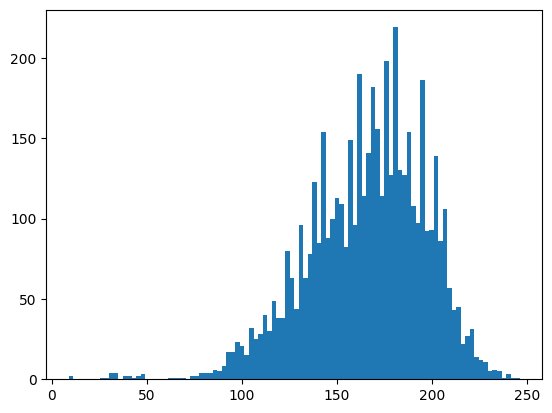

In [74]:
plt.hist(decompositions,100);

In [23]:

tasks = dc.domains.quantum_circuits.tasks.makeTasks()
primitives = [
    pr.p_hadamard,
    pr.p_t,
    pr.p_tdg,
    # pr.p_cnot,
    # pr.p_x,
]
grammar = Grammar.uniform(primitives) # continuationType=tcircuit not supported (non-unary argument)

generator = dc.dreamcoder.ecIterator(
    grammar=grammar,
    tasks=tasks,
    testingTasks=[],
    outputPrefix=f"experimentOutputs/quantum/{datetime.now().isoformat()}",
    enumerationTimeout=50,
    iterations=3,
    taskBatchSize=len(tasks),  # smaller should be faster
    taskReranker="randomShuffle",  # default
    CPUs=1,#numberOfCPUs(),
    solver="bottom",
    compressor="pypy",
    **enum_settings,
    **library_settings,
)

In [24]:
for result in generator:
    ...

dreamcoder.py:191 > Warning: Recognition model needs feature extractor. Ignoring recognition model.
dreamcoder.py:270 > Running EC on polymathiclin033.flatironinstitute.org @ 2024-08-21 02:02:21.767585 with 1 CPUs and parameters:
dreamcoder.py:273 > 	 noConsolidation  =  False
dreamcoder.py:273 > 	 iterations  =  3
dreamcoder.py:273 > 	 enumerationTimeout  =  50
dreamcoder.py:273 > 	 useRecognitionModel  =  False
dreamcoder.py:273 > 	 topk_use_only_likelihood  =  False
dreamcoder.py:273 > 	 pseudoCounts  =  10
dreamcoder.py:273 > 	 aic  =  1.0
dreamcoder.py:273 > 	 structurePenalty  =  6
dreamcoder.py:273 > 	 arity  =  3
dreamcoder.py:273 > 	 taskBatchSize  =  5500
dreamcoder.py:273 > 	 taskReranker  =  randomShuffle
dreamcoder.py:273 > 	 storeTaskMetrics  =  False
dreamcoder.py:273 > 	 rewriteTaskMetrics  =  True
dreamcoder.py:273 > 	 maximumFrontier  =  1
dreamcoder.py:273 > 	 solver  =  bottom
dreamcoder.py:273 > 	 topK  =  2
dreamcoder.py:274 > 	 evaluationTimeout  =  1.0
dreamcode

enumeration.py:78 > Disabling parallelism on the Python side because we only have one job.
enumeration.py:79 > If you are using ocaml or bottom, there could still be parallelism.
enumeration.py:163 > (frontend) Launching int -> tcircuit -> tcircuit (5500 tasks) w/ 1 CPUs. 0.000000 <= MDL < 100.000000. Timeout 50.000000.
grammar.py:2048 >  -- Bottom up enumeration, cost 0
grammar.py:2048 >  -- Bottom up enumeration, cost 1
grammar.py:2048 >  -- Bottom up enumeration, cost 2
grammar.py:2048 >  -- Bottom up enumeration, cost 3
grammar.py:2048 >  -- Bottom up enumeration, cost 4
grammar.py:2048 >  -- Bottom up enumeration, cost 5
grammar.py:2048 >  -- Bottom up enumeration, cost 6
grammar.py:2048 >  -- Bottom up enumeration, cost 7
grammar.py:2048 >  -- Bottom up enumeration, cost 8
grammar.py:2048 >  -- Bottom up enumeration, cost 9
grammar.py:2048 >  -- Bottom up enumeration, cost 10
grammar.py:2048 >  -- Bottom up enumeration, cost 11
grammar.py:2048 >  -- Bottom up enumeration, cost 12

In [25]:
# 50
code = " (lambda (lambda (h (t (h (t (h (t (h (t (h (t (h (t (h (t (h (t (h (t (h (t (h (t (h (t (h (t (h $0 $1) $1) $1) $1) $1) $1) $1) $1) $1) $1) $1) $1) $1) $1) $1) $1) $1) $1) $1) $1) $1) $1) $1) $1) $1) $1) $1)))"
program = Program.parse(code)
grammar.logLikelihood(tasks[-1].request, program)

-38.816242111356935

In [19]:
#100
code = " (lambda (lambda (h (t (h (t (h (t (h (t (h (t (h (t (h (t (h (t (h (t (h (t (h (t (h (t (h $0 $1) $1) $1) $1) $1) $1) $1) $1) $1) $1) $1) $1) $1) $1) $1) $1) $1) $1) $1) $1) $1) $1) $1) $1) $1)))"
program = Program.parse(code)
grammar.logLikelihood(tasks[-1].request, program)

-36.04365338911715

In [22]:
#200
code = "(lambda (lambda (h (t (h (t (h (t (h (t (h (t (h (t (h (t (h (t (h (t (h (t (h (t (h (t (h (t (h (t (h $0 $1) $1) $1) $1) $1) $1) $1) $1) $1) $1) $1) $1) $1) $1) $1) $1) $1) $1) $1) $1) $1) $1) $1) $1) $1) $1) $1) $1) $1)))"
program = Program.parse(code)
grammar.logLikelihood(tasks[-1].request, program)

-41.58883083359672